In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.colors as mcolors

# This Formatting Code is From Felipe Alaracon
# It does nothing other than make my code look nice
# I've made small changes
mpl.rc('figure',
       titlesize=24,
       figsize=(12,10),
      dpi=250,
      edgecolor='black',
    facecolor='white'
      )

mpl.rcParams['font.family'] = 'Arial' # 'sans-serif' , 'cursive' , 'fantasy','monospace' (e.g., Courier)

mpl.rc('lines',
       linewidth=2,
       color='r',
      linestyle='-',
      markersize=6,
      dash_joinstyle='miter', # miter/round/bevel
      dash_capstyle='butt',  #butt/round/projecting
      solid_joinstyle='miter',
      solid_capstyle='projecting',
      dashed_pattern= (2.8, 1.2),
       dashdot_pattern= (4.8, 1.2, 0.8, 1.2),
       dotted_pattern = (1.1, 1.1),
       scale_dashes = True
      )

mpl.rc('legend',
      fancybox=True, # if True, use a rounded box for the
      numpoints=1, # the number of marker points in the legend line
      markerscale =1,
      fontsize = 'medium',
      borderaxespad = 0.5) # the border between the axes and legend edge
             
mpl.rc('axes',
      facecolor='white',
      edgecolor='black',
      linewidth=1.9,
      grid=False,
      titlesize='large',
      labelsize='large',
      labelcolor='black',
      axisbelow='False') #draw axis gridlines and ticks below, patches (True); above patches but below, lines ('line'); or above all (False) 

mpl.rc('grid',
        color= 'lightgray',
       linestyle=':',
       linewidth=.6,
       alpha=.8)

mpl.rc('xtick',
      top=True, 
      bottom=True, 
      color ='k',
      labelsize = 'medium',
      direction = 'in') 

mpl.rc('xtick.major',
      size=3.5,
      width=1.2,
      pad=3.5,
      top=True,
      bottom=True)

mpl.rc('xtick.minor',
      size=2,
      width=0.8,
      pad=3.4,
      top=True,
      bottom=True)

mpl.rc('ytick',
      right=False, 
      left=True, 
      color ='k',
      labelsize = 'medium',
      direction = 'in') 

mpl.rc('ytick.major',
      size=3.5,
      width=1.2,
      pad=3.5,
      left=True,
      right=True)

mpl.rc('ytick.minor',
      size=2,
      width=0.8,
      pad=3.4,
      left=True,
      right=True)

In [59]:
import numpy as np
import math

from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import inset_axes




def tprof(lons,lats,press,data,oom,surfp,nlay,runname,path,
              savefig,savename):
    lon_arr=lons
    lat_arr=lats
    nlon=len(lon_arr)
    nlat=len(lat_arr)
    p_BAR=press
    ind=5 #temperature index from orl_sav 
    
    
    # Define the colormap
    colors1 = plt.cm.gist_rainbow(np.linspace(0, 1, nlon+4))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors1)

    data_26=np.copy(data[:,:,:,ind])
    minV=np.int((np.nanmin(data_26)))*1.0
    maxV=np.ceil(np.nanmax(data_26))
    sigma=np.empty([nlay])*0.0
    if oom>0: #setting up pressure values 
        stp=-1.0*oom/nlay
        sigma[nlay-1]=10.**(stp/2.)
        for n in range(nlay-2,-1,-1):
            sigma[n]=sigma[n+1]*10.**(stp)

    p_BAR=sigma*surfp
    with open(path+runname+'/'+'fort.50','r') as data_50:  #fort_50 long1 lat1 pressure 
        specificp=np.zeros((48,96))  #lat,long               #long1 lat2 pressure
        acount=0
        bcount=0
        next(data_50)
        for line in data_50:
            p=line.split()
            if bcount<48 and acount<96:
                specificp[bcount][acount]=((float(p[2]))+1)*surfp
                bcount=bcount+1
            else:
                if acount<96:
                    acount=acount+1
                    bcount=0
                    if acount<96:
                        specificp[bcount][acount]=((float(p[2]))+1)*surfp
                        bcount=bcount+1
                
                
    #setting up some lines
    eqline=[]
    count=0
    others=np.zeros((48,96,nlay)) #lat, lon, layer
    pressures=np.zeros((48,96,nlay)) #specific set of pressure for each line 
    eqlines = [[] for i in range(len(lon_arr))]
    while count<nlay:
        eqline.append(data_26[count,0,24]) #latitude 24 is -1.8556 deg, closest to equator
        count=count+1
    lolcount=0
    layercount=0
    longcount=0
    latcount=0
    while layercount<nlay: #fill in the non-eq lines
        if latcount< len(lat_arr):
            others[latcount][longcount][layercount]=data_26[layercount,longcount,latcount]
            pressures[latcount][longcount][layercount]=specificp[latcount][longcount]*sigma[layercount]
            latcount=latcount+1
        else:
            if longcount< len(lon_arr)-1:
                longcount=longcount+1
                latcount=0
            elif layercount!= nlay-1:
                longcount=0
                latcount=0
                layercount=layercount+1
            else:
                layercount=555
    i=0
    while i<nlay: #fill in the eqlines 
        if lolcount<len(lon_arr):
            eqlines[lolcount].append(data_26[i,lolcount,24])
    
            lolcount=lolcount+1
        else:
            if i!=44:
                lolcount=0
                i=i+1
            else:
                i=45
    i=0
    j=0
    k=0
    mpl.rcParams.update({'font.size': 16})
    print ('info coming!')
    print (pressures[5][10][0])
    print (p_BAR[0])
    print (pressures[7][11][0])
    #fig, ax1 = plt.subplots(nrows=1, figsize=(8,9), gridspec_kw={'height_ratios': [8, .45]} )
    fig, ax1 = plt.subplots(figsize=(8,9))
    while j<len(lon_arr):
        if i<len(lat_arr):
            ax1.plot(others[i][j],pressures[i][j], color='grey')
            i=i+1
        else:
            i=0
            j=j+1
    while k<len(lon_arr): #plot the equator lines in color
        ax1.plot(eqlines[k],pressures[2][k], color=colors1[k])
        k=k+1
    ax1.set_yscale('log')
    ax1.invert_yaxis()
    ax1.set_ylabel('Pressure',size='large')
    ax1.set_xlabel('Temperature (Kelvin)',size='large')
    ax1.text(900,10,'Longitude', size='large')

    cmap = mymap
    norm = mpl.colors.Normalize(vmin=0, vmax=360)
    cmap2 = mpl.cm.ScalarMappable(norm = norm, cmap = plt.get_cmap(mymap))
    cmap2.set_array([])

    #cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
     #                           norm=norm,
      #                          orientation='horizontal')
    #cb1.set_label('Latitude',size='large')
    cbaxes=inset_axes(ax1,width="6%", height="30%",loc=3)
    #consider: no label, just place text 
    fig.colorbar(cmap2, cax=cbaxes, ticks=[0,360], orientation='vertical')
    fig.show()
    if savefig==True:
        fig.savefig(savename,rasterized=True,transparent=True,bbox_inches = 'tight')
    #plt.show()

In [60]:
import numpy as np
import math

from scipy.io import readsav

def load_data(path,runname,oom, surfp, LO,OLR,ver,fort_file):
    #runname=raw_input('Run Name?:')
    #oom=input('Pressure OOM?:')
    #surfp=input('Surface Press [bar]:')
    

    ####################### READ 26 #########################
    with open(path+runname+'/'+fort_file) as f:
        first_line=f.readline()
        nlat,nlon,nlev=first_line.split()
        nlat,nlon,nlev=int(nlat),int(nlon),int(nlev)

    f.close()
    
    data26=np.empty([nlon*nlat*nlev, 6])
    
    
    
    l=0
    lp=0
    with open(path+runname+'/'+fort_file) as f:
        for line in f:
            if l==0:
                l+=1
                continue
            elif l%2==1 and l<=nlon*nlat*nlev*2.:
                line_pair=np.empty([6])
                lon, lat, lev, u, v = line.split()
                line_pair[:5] = np.float32(lon), np.float32(lat), int(lev), np.float32(u), np.float32(v)
            elif l%2==0 and l<=nlon*nlat*nlev*2.:
                line_pair[5]=np.float32(line)
                data26[lp,:]=line_pair
                lp+=1
            elif l>nlon*nlat*nlev*2.:
                break
            l+=1
    f.close()

    lon_arr_f=data26[:,0]
    lon_arr=np.array([])
    for l in range(0,len(lon_arr_f)):
        el=lon_arr_f[l]
        if not el in lon_arr:
            lon_arr=np.append(lon_arr,el)

    lat_arr_f=data26[:,1]
    lat_arr=np.array([])
    for l in range(0,len(lat_arr_f)):
        el=lat_arr_f[l]
        if not el in lat_arr:
            lat_arr=np.append(lat_arr,el)

    lev_arr_f=data26[:,2]
    lev_arr=np.array([])
    for l in range(0,len(lev_arr_f)):
        el=lev_arr_f[l]
        if not el in lev_arr:
            lev_arr=np.append(lev_arr,el)

    #data26=np.reshape(data26,[nlon,nlat,nlev,6])
    #print data26.shape
    data_26=np.empty([nlev,nlon,nlat,6])
    for l in range(0,data26.shape[0]):
        lon,lat,lev=data26[l,:3]
        lon_i,lat_i,lev_i=np.where(lon_arr==lon)[0][0],np.where(lat_arr==lat)[0][0],np.where(lev_arr==lev)[0][0]
        data_26[lev_i,lon_i,lat_i,:]=data26[l,:]
    ############################################################
    #data_26=readsav(path+runname+'/atm_wind_temp.sav')['xy']
    nlev,nlon,nlat,nparam=data_26.shape
    
    if LO==True:
        data_lo=readsav(path+runname+'/finalorb.sav')['all_dat']
    else:
        data_lo=np.empty(data_26.shape)
    if OLR==True:
        data_olr=readsav(path+runname+'/olr.sav')['olr']
    else:
        data_olr=np.empty(data_26.shape)


    sigma=np.empty([nlev])*0.0
    if oom==0:
        stp=1.0/(nlev+1.)
        sigma[nlev-1]=1.0-stp
        for n in range(nlev-2,-1,-1):
            sigma[n]=sigma[n+1]-stp
    if oom>0:
        stp=-1.0*oom/nlev
        sigma[nlev-1]=10.**(stp/2.)
        for n in range(nlev-2,-1,-1):
            sigma[n]=sigma[n+1]*10.**(stp)

    p_BAR=sigma*surfp

    lat_arr=data_26[0,0,:,1]
    lon_arr=data_26[0,:,0,0]

    return runname,lon_arr,lat_arr,oom,surfp,p_BAR,data_26,data_lo,data_olr

In [61]:

#path = '/home/imalsky/Documents/Data/fort_files'
path = '/home/imalsky/Documents/UpsAndb/Low_gravity'
#runname = '/clear_low_grav'
runname = '/cloudy'

oom = 6
surfp = 100
LO = False
OLR =False
verbose=False
fort_file= 'fort.26'

runname, lon_arr, lat_arr, oom, surfp, p_BAR, data_26, data_lo, data_olr = load_data(path, runname, oom, surfp, LO, OLR, verbose, fort_file)

info coming!
0.00011877892871747714
0.00011659144011798354
0.00011827373800744594


/home/imalsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


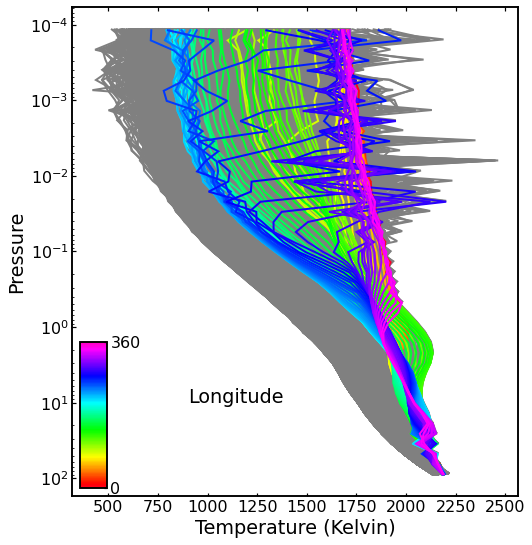

In [62]:
#from tprof import tprof
#reads in fort.50 
nlay=45     #number of layers

savefig=True
#path = '/home/imalsky/Documents/Data/fort_files'
#runname = '/clear_low_grav'
savename = '/home/imalsky/Desktop/low_grav_cloudy.pdf' 

%matplotlib inline
tprof(lon_arr, lat_arr, p_BAR, data_26, oom, surfp, nlay, runname, path, savefig, savename)